## About Problem:
The data set used is a collection of accelerometer data taken from a smartphone that various people carried with them while conducting six different exercises (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking). For each exercise the acceleration for the x, y, and z axis was measured and captured with a timestamp and person ID. We would train a neural network in order to understand if a person carrying a smartphone is performing any of the six activities.

Let's start by importing all the libraries needed.

In [1]:
import tensorflow as tf #To show the version used at the time of creation of this file.
print(tf.__version__)

2.1.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [15]:
columns = ['user_id','activity','timestamp','x','y','z']
path="WISDM_ar_v1.1\\WISDM_ar_v1.1_raw.txt"
df = pd.read_csv(path, header = None, names = columns)
df.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [16]:
#We can see that last column need some preprocessing
df['z']=df['z'].str.strip()
df['z']=df['z'].str.replace(';','')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x          1098204 non-null  float64
 4   y          1098204 non-null  float64
 5   z          1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [17]:
#Converting last column type to float and dropping the null values 
df['z']=df['z'].astype('float64')
index=df[df['z'].isnull()].index[0]
df.drop(index=index,axis=0,inplace=True)

In [18]:
df.isnull().any()

user_id      False
activity     False
timestamp    False
x            False
y            False
z            False
dtype: bool

In [19]:
#The data is imbalanced
df['activity'].value_counts()/len(df)*100

Walking       38.644677
Jogging       31.157810
Upstairs      11.188187
Downstairs     9.144666
Sitting        5.457916
Standing       4.406744
Name: activity, dtype: float64

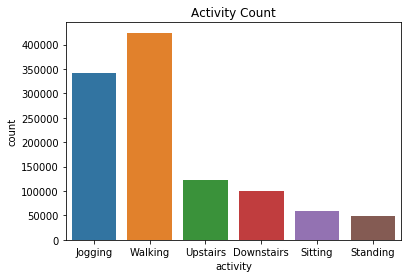

In [20]:
sns.countplot(data=df,x='activity')
plt.title('Activity Count')
plt.show()

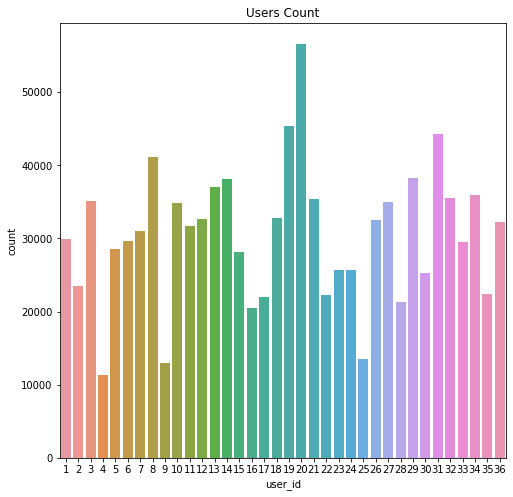

In [21]:
plt.figure(figsize=(8,8))
sns.countplot(data=df,x='user_id')
plt.title('Users Count')
plt.show()

In [22]:
fs=20 #The data is recorded at a sampling rate of 20 Hz (20 records per second).

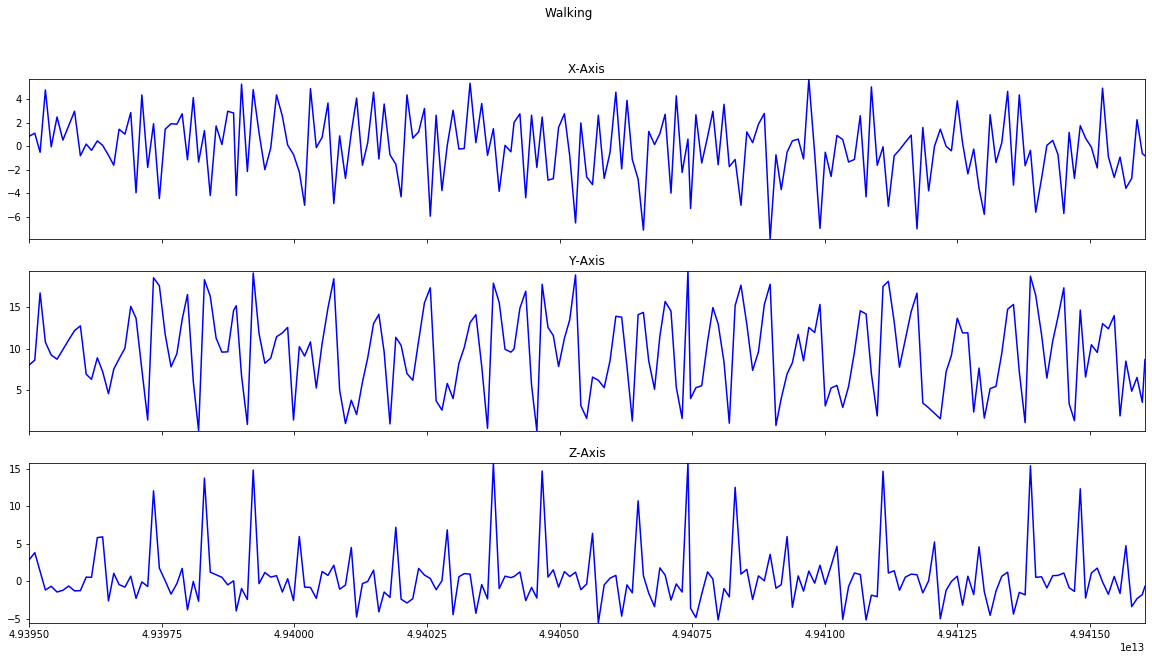

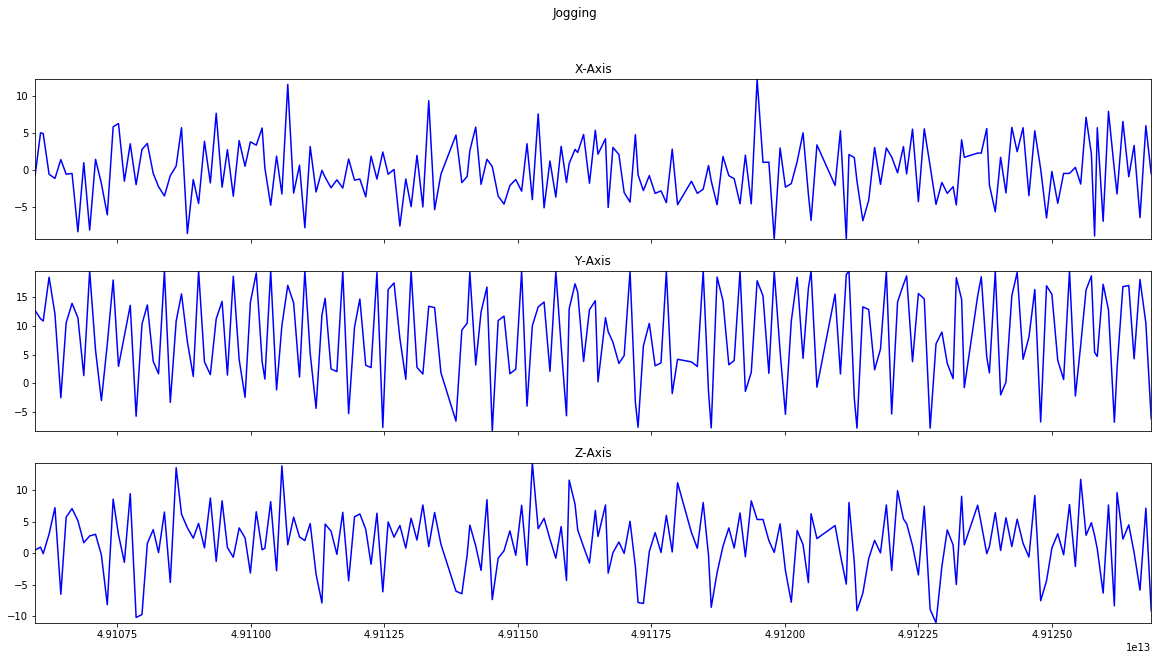

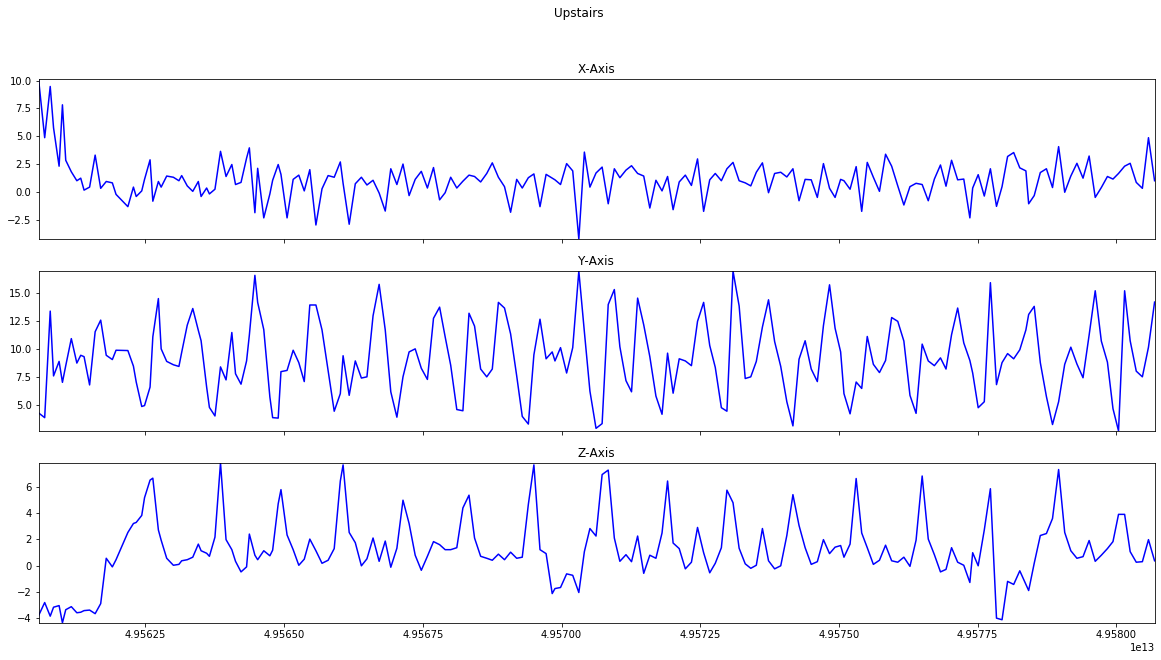

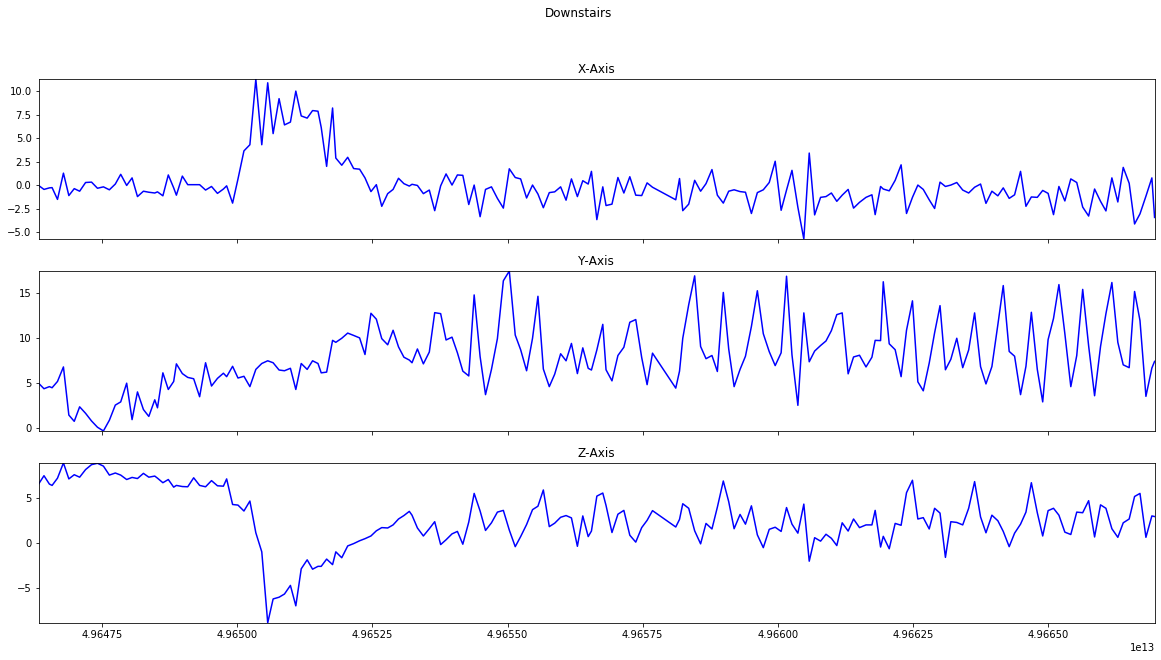

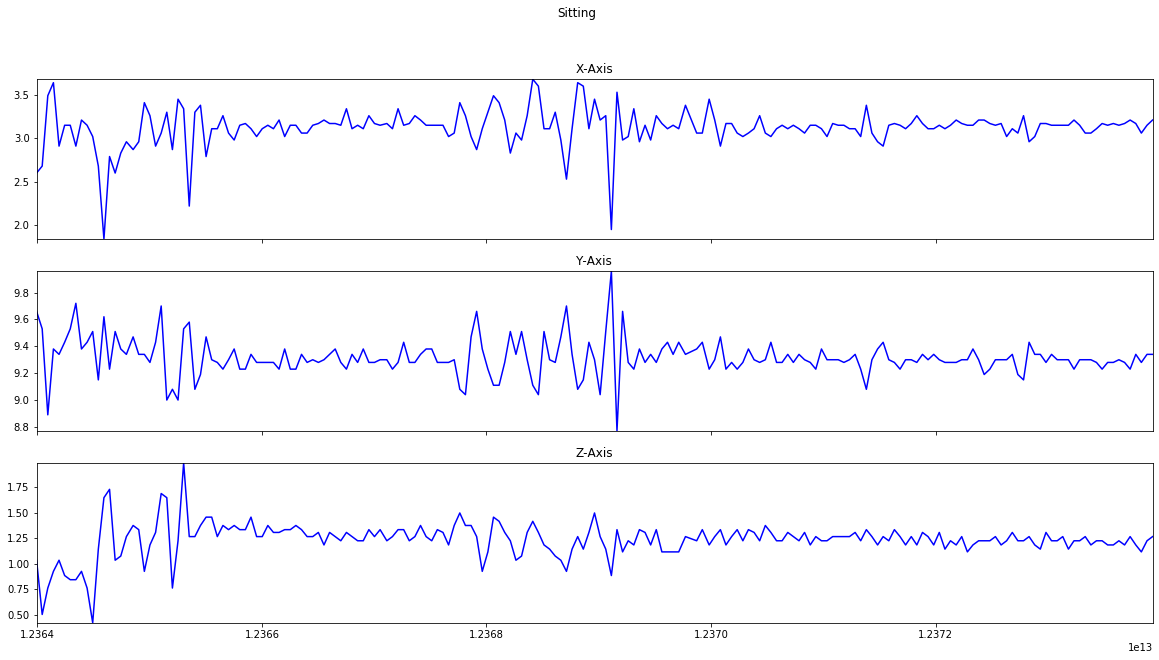

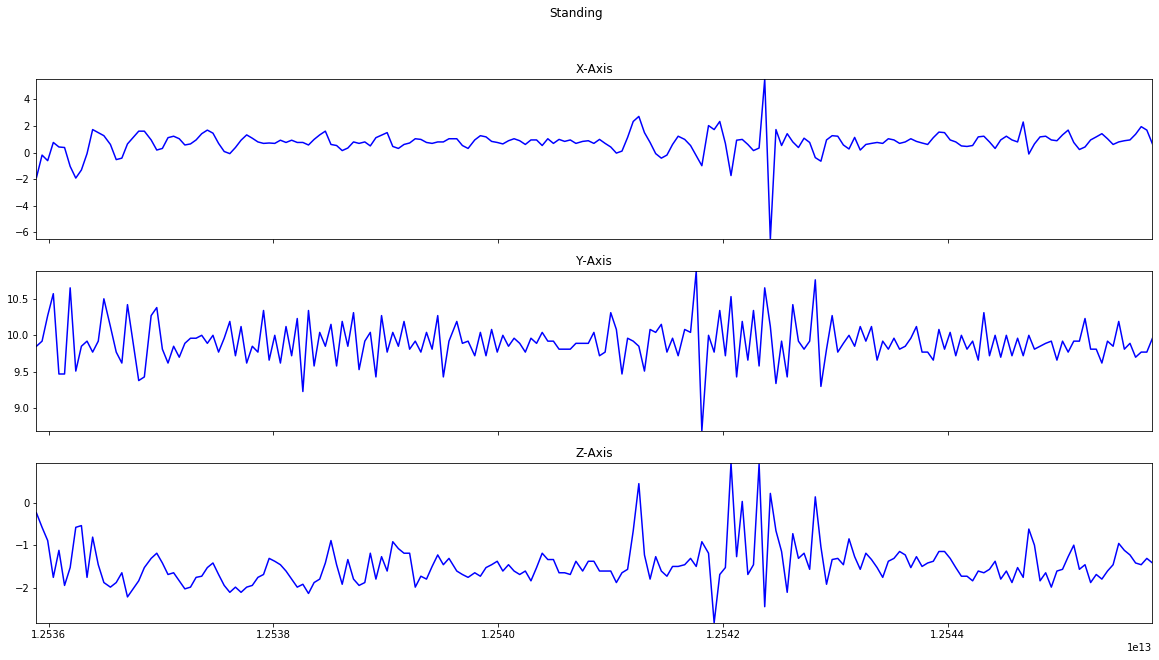

In [23]:
#Plotting the data and watch fluctuations in different axes for each activity
def plot1(ax, x, y, title):

    ax.plot(x, y, 'b')
    ax.set_title(title)
    ax.set_ylim([min(y), max(y)])
    ax.set_xlim([min(x), max(x)])

    
def plot2(activity, data):

    fig, (axX, axY, axZ) = plt.subplots(nrows=3,figsize=(20, 10),sharex=True)
    plot1(axX, data['timestamp'], data['x'], 'X-Axis')
    plot1(axY, data['timestamp'], data['y'], 'Y-Axis')
    plot1(axZ, data['timestamp'], data['z'], 'Z-Axis')
    fig.suptitle(activity)
    plt.show()


for activity in df['activity'].value_counts().index:
    records = df[df['activity'] == activity][:fs*10] #fs*10 means we are plotting data for 10 seconds i.e. 200 records.
    plot2(activity, records)

We can see that the fluctuation are more evident for acitivies like Jogging or Walking and more subtle for activities like Sitting or Standing. Also, if we note, the pattern for Downstairs and Upstairs are pretty similar.

In [24]:
df.drop(columns=['user_id','timestamp'],inplace=True) #These two do not contribute to the problem, we just need three axes.

In [25]:
le=LabelEncoder() #Encoding 6 acitivities so that we can feed it into neural network
df['activity']=le.fit_transform(df['activity'])

In [26]:
#Scaling data
for column in ['x','y','z']:
    scaler=StandardScaler()
    df[column]=scaler.fit_transform(pd.DataFrame(df[column]))

In [27]:
#Reshape and prepare Data into frames and labels with each record as 10 seconds of activity 
#with some overlap in consecutive records.
fs=20
frame_size=fs*10
n_features=3
step=20
frames=[]
labels=[]
for i in range(0,len(df)-frame_size,step):
    x=df['x'].values[i:i+frame_size]
    y=df['y'].values[i:i+frame_size]
    z=df['z'].values[i:i+frame_size]
    label = mode(df['activity'][i: i + frame_size])[0][0]
    frames.append([x, y, z])
    labels.append(label)
frames=np.asarray(frames).reshape(-1,frame_size,n_features)
labels=np.asarray(labels)

In [28]:
frames.shape,labels.shape

((54901, 200, 3), (54901,))

In [29]:
#Split data into train and test sets
X_train,X_test,Y_train,Y_test=train_test_split(frames,labels,test_size=0.2,random_state=100,stratify=labels)

In [30]:
#We jave to reshape our data into 3D inputs as CNNs in Keras expect a 3D input.
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [32]:
#Building the structure of the model.
model=Sequential()
model.add(Conv2D(16,(2,2),activation='relu',input_shape=X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32,(2,2),activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6,activation='softmax'))

In [33]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [34]:
#Now the fund part, let's train the model and test it's accuracy on the test set.
history=model.fit(X_train,Y_train,epochs=10,validation_data=(X_test,Y_test))

Train on 43920 samples, validate on 10981 samples
Epoch 1/10
43920/43920 [==============================] - 40s 917us/sample - loss: 0.5109 - accuracy: 0.8146 - val_loss: 0.2928 - val_accuracy: 0.8854
Epoch 2/10
43920/43920 [==============================] - 41s 932us/sample - loss: 0.2904 - accuracy: 0.8922 - val_loss: 0.1837 - val_accuracy: 0.9306
Epoch 3/10
43920/43920 [==============================] - 43s 969us/sample - loss: 0.2127 - accuracy: 0.9233 - val_loss: 0.1596 - val_accuracy: 0.9409
Epoch 4/10
43920/43920 [==============================] - 41s 943us/sample - loss: 0.1737 - accuracy: 0.9373 - val_loss: 0.1756 - val_accuracy: 0.9297
Epoch 5/10
43920/43920 [==============================] - 42s 950us/sample - loss: 0.1486 - accuracy: 0.9458 - val_loss: 0.1135 - val_accuracy: 0.9603
Epoch 6/10
43920/43920 [==============================] - 42s 951us/sample - loss: 0.1292 - accuracy: 0.9533 - val_loss: 0.1041 - val_accuracy: 0.9606
Epoch 7/10
43920/43920 [====================

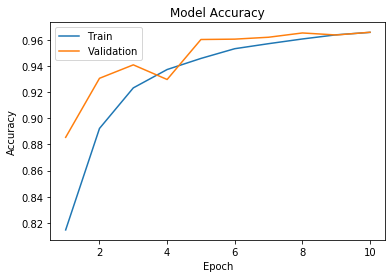

In [35]:
#Plotting Accuracy curve for each epoch
def learning_curve(history,epochs):
    epoch_range=range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'],loc=0)
    plt.show()
learning_curve(history,10)

In [36]:
#Save predictions as a confusion matrix.
Y_pred=model.predict_classes(X_test)
matrix=confusion_matrix(Y_test,Y_pred)

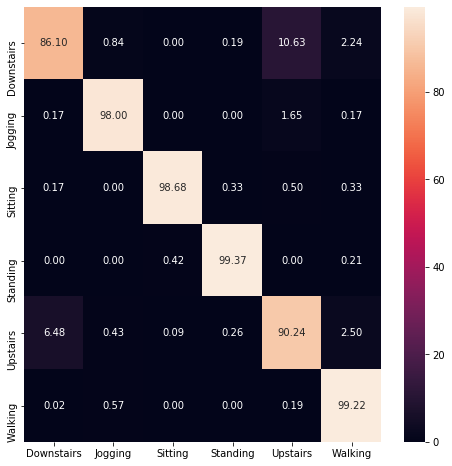

In [37]:
#This is to plot the confusion matrix and convert it's predictions in percentages for each category
sum1=0
list1=[]
for j in range(0,6):
    sum1=matrix[:,j].sum()
    for i in range(0,6):
        list1.append(matrix[i,j]/sum1)
new_matrix=np.asarray(list1).reshape(6,6)
new_matrix=new_matrix*100
plt.figure(figsize=(8,8))
sns.heatmap(new_matrix,annot=True,fmt='.2f',xticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'],yticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'])
plt.show()

This is very good, **an accuracy of 96.5%**, considering the model is relatively simple and the optimizer or hyper-parameters used are pretty standrad. I believe this can be fine tuned to an accuracy of upto 98%.

But we can see that the model mainly got confused between upstairs and downstairs activities, which is understandable and if we further try to learn the pattern differences in upstairs and downstairs then it **might** overfit for rest of the acivities.  